<a href="https://colab.research.google.com/github/NBandemer/capstone-mayo/blob/t5/T5_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Necessary libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
import datetime
import os
import warnings
import json

import torch
from torch.optim import AdamW
from transformers import T5ForSequenceClassification, T5Tokenizer, TrainingArguments, Trainer
from torch.utils.data import Dataset, DataLoader
from transformers import EarlyStoppingCallback
from transformers import get_linear_schedule_with_warmup
from tensorboard.backend.event_processing import event_accumulator

In [2]:
# data preprocessing and train-test split
# load the preprocessed dataset from a CSV file
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/PREPROCESSED-NOTES.csv")

# extract text data and specific SDoH categories from the dataset
text_data = dataset["text"].to_list()
sdoh_data = {
    "sdoh_community_present": dataset["sdoh_community_present"].to_list(),
    "sdoh_community_absent": dataset["sdoh_community_absent"].to_list(),
    "sdoh_education": dataset["sdoh_education"].to_list(),
    "sdoh_economics": dataset["sdoh_economics"].to_list(),
    "sdoh_environment": dataset["sdoh_environment"].to_list(),
    "behavior_alcohol": dataset["behavior_alcohol"].to_list(),
    "behavior_tobacco": dataset["behavior_tobacco"].to_list(),
    "behavior_drug": dataset["behavior_drug"].to_list()
}

# prepare directories for storing train-test split data for each SDoH category
base_path = 'test_train_split/behavior_drug'
os.makedirs(base_path, exist_ok=True)

# Iterate through each SDOH data category to split and save as separate CSV files
for category, data in sdoh_data.items():
    base_path = f"test_train_split/{category}"
    os.makedirs(base_path, exist_ok=True)

    # Split data for the current category into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        text_data, data, random_state=0, train_size=0.8, stratify=data
    )

    # Save all splits as CSV files
    pd.DataFrame({"text": X_train}).to_csv(f"{base_path}/X_train.csv", index=False)
    pd.DataFrame({"text": X_val}).to_csv(f"{base_path}/X_val.csv", index=False)
    pd.DataFrame({category: y_train}).to_csv(f"{base_path}/y_train.csv", index=False)
    pd.DataFrame({category: y_val}).to_csv(f"{base_path}/y_val.csv", index=False)

In [3]:
# Functions

def save_metrics_to_csv(json_filepath, csv_filename):
    with open(json_filepath) as file:
        data = json.load(file)

        log_history = data['log_history']
        df = pd.DataFrame(log_history)

        df.to_csv(csv_filename, index=False)

def plot_metric_from_tensor(log_dir, output_dir, steps_per_epoch):

    # Calculate steps_per_epoch based on training data and training arguments
    # steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    graph1_data = event_acc.Scalars("eval/loss")
    graph2_data = event_acc.Scalars("train/loss")

    # convert steps to epochs
    epochs1 = [event.step / steps_per_epoch for event in graph1_data]
    values1 = [event.value for event in graph1_data]

    epochs2 = [event.step / steps_per_epoch for event in graph2_data]
    values2 = [event.value for event in graph2_data]

    plt.figure(figsize=(10, 6))

    plt.plot(epochs1, values1, label="Validation Loss")
    plt.plot(epochs2, values2, label="Train Loss")

    plt.legend()

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Overlap")
    # plt.show()

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Save the graph to the specified folder
    plt.savefig(os.path.join(output_dir, 'metrics_plot.png'))
    plt.show()

# evaluation metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def get_latest_checkpoint(folder_path):
    # Get a list of all files and directories in the specified folder
    files_and_dirs = os.listdir(folder_path)

    # Filter only directories (assumed to be checkpoints)
    checkpoint_dirs = [d for d in files_and_dirs if os.path.isdir(os.path.join(folder_path, d))]

    if not checkpoint_dirs:
        print("No checkpoint directories found.")
        return None

    # Extract the checkpoint numbers from the directory names
    checkpoint_numbers = [int(d.split('-')[1]) for d in checkpoint_dirs]

    # Identify the directory with the highest checkpoint number
    latest_checkpoint = os.path.join(folder_path, f"checkpoint-{max(checkpoint_numbers)}")

    return latest_checkpoint

checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/checkpoints/checkpoint_epoch_{epoch}.pth'
best_model_path = '/content/drive/MyDrive/Colab Notebooks/Capstone/checkpoints/best_model.pth'


# Saving the checkpoints
def save_checkpoint(model, optimizer, epoch, loss, val_loss, is_best=False):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    if is_best:
        torch.save(model.state_dict(), best_model_path)

In [5]:
# Define label_columns here
label_columns = [
    'sdoh_community_present', 'sdoh_community_absent', 'sdoh_education',
    'sdoh_economics', 'sdoh_environment', 'behavior_alcohol',
    'behavior_tobacco', 'behavior_drug'
]

sbdh_substance = {
    0: 'None',
    1: 'Present',
    2: 'Past',
    3: 'Never',
    4: 'Unsure'
}

sbdh_econ_env = {
    0: 'None',
    1: 'True',
    2: 'False',
}

sbdh_community_ed = {
    0: 'False',
    1: 'True',
}

# !!!!!!! CHANGE THESE SDOH ALWAYS !!!!!
dataset['sdoh_economics'] = dataset.sdoh_economics.map(sbdh_econ_env)
current_sboh = 'sdoh_economics'

num_labels = len(sbdh_econ_env)

tokenizer = T5Tokenizer.from_pretrained("t5-small", num_labels=num_labels)
#tokenizer = T5Tokenizer.from_pretrained("t5-small", num_labels=num_labels)
#tokenizer.pad_token = tokenizer.eos_token

configuration = T5ForSequenceClassification.config_class.from_pretrained("t5-small", num_labels=num_labels)
#configuration = T5ForSequenceClassification.config_class.from_pretrained("t5-small", num_labels= num_labels)
configuration.pad_token_id = tokenizer.pad_token_id
model = T5ForSequenceClassification(configuration)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_featu

In [6]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5)

In [12]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/PREPROCESSED-NOTES.csv")
text_data = dataset["text"].to_list()
sdoh_data = dataset["sdoh_economics"].to_list() # THIS ALSO

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(text_data, sdoh_data, random_state=0, train_size=0.8,
                                                  stratify=sdoh_data)
max_seq_length = 100

# Calculate the number of trainable parameters in the model
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
model_size_MB = num_trainable_params * 4 / (1024 ** 2)
effective_batch = 8 / (50*4*model_size_MB) #gpu/seqlength * 4 * model size

In [8]:
# define training arguments and start training with the Trainer
train_encodings = tokenizer(X_train, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
val_encodings = tokenizer(X_val, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')

In [9]:
# IMPORTANT: change label to float for sdoh_economics, sdoh_environment

class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        try:
            # Retrieve tokenized data for the given index
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            # Add the label for the given index to the item dictionary

            # item['labels'] = torch.tensor(float(self.labels[idx]))
            item['labels'] = self.labels[idx]

            return item
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            return None

    def __len__(self):
        return len(self.labels)

In [10]:
train_dataset = DataLoader(train_encodings, y_train)
val_dataset = DataLoader(val_encodings,y_val)

In [10]:
timestamp_fortrain = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

tensor_logs = f'/content/drive/MyDrive/Colab Notebooks/Capstone/logs/tensor_logs/{timestamp_fortrain}' # create seperate logs for tensor/epoch
os.makedirs(tensor_logs, exist_ok=True)
epoch_logs = f'/content/drive/MyDrive/Colab Notebooks/Capstone/logs/epoch_logs/{timestamp_fortrain}'
os.makedirs(epoch_logs, exist_ok=True)

In [12]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

# training args - need to adjust
training_args = TrainingArguments(
      output_dir= epoch_logs,  # change to epoch log directory, convert to a text
      logging_strategy='epoch',  # characterize as epoch
      num_train_epochs=20, # have high epoch
      #per_device_train_batch_size=64,  # cpu constraint,  64 approp
      per_device_train_batch_size=64, #reduced batch size
      per_device_eval_batch_size=64,  # gradient accum if batch size of two, 64 approp
      save_strategy= 'epoch',
      warmup_steps=500,
      weight_decay=0.02,
      logging_dir= tensor_logs,  # change to tensor logs
      #eval_steps=100,
      evaluation_strategy="epoch",
      #accumulate gradients over 4 steps
      #gradient_accumulation_steps = 4
      load_best_model_at_end=True,  # This will load the best model at the end of training
      metric_for_best_model="eval_loss",  # Use eval_loss to determine the best model
      greater_is_better=False,  # Set to False because a lower loss is better
      learning_rate=5e-6,
      lr_scheduler_type='linear',

)

trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      compute_metrics=compute_metrics,
      #callbacks=[early_stopping],
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


<ipython-input-9-fa0b3b671f5d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.743400,0.156656,0.970107,0.955387,0.941107,0.970107
2,0.142100,0.141659,0.970107,0.955387,0.941107,0.970107
3,0.136300,0.133005,0.970107,0.955387,0.941107,0.970107
4,0.127300,0.123995,0.970107,0.955387,0.941107,0.970107
5,0.118800,0.114945,0.970107,0.955387,0.941107,0.970107
6,0.100700,0.096724,0.976512,0.970444,0.973797,0.976512
7,0.078500,0.161370,0.935231,0.947876,0.965899,0.935231
8,0.068600,0.107604,0.980783,0.977240,0.979355,0.980783
9,0.053700,0.106710,0.982918,0.980311,0.981851,0.982918
10,0.045900,0.094548,0.978648,0.977244,0.976527,0.978648


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-fa0b3b671f5d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-9-fa0b3b671f5d>:11: UserWarning: To copy construct from a tensor, it is recomm

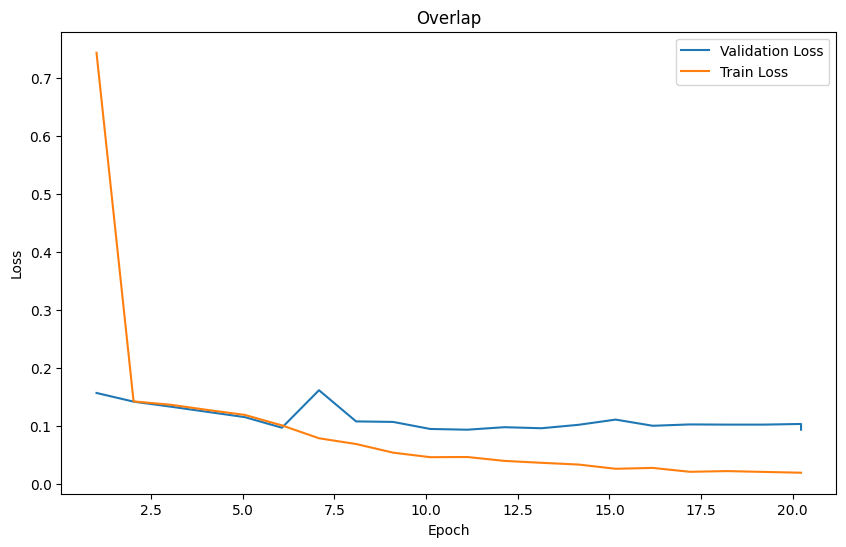

Evaluation Results: {'eval_loss': 0.09329067170619965, 'eval_accuracy': 0.9772241992882562, 'eval_f1': 0.976954794521594, 'eval_precision': 0.9767081198753798, 'eval_recall': 0.9772241992882562, 'eval_runtime': 4.5524, 'eval_samples_per_second': 308.626, 'eval_steps_per_second': 4.833, 'epoch': 20.0}


In [13]:
# train the model
trainer.train()

# evaluate the model
evaluation_results = trainer.evaluate()

# Save checkpoint after every epoch
#save_checkpoint(model, optimizer, epoch, current_loss, current_val_loss, is_best=False)

#readable results
steps_per_epoch = len(train_dataset) // training_args.per_device_train_batch_size
latest_checkpoint = get_latest_checkpoint(epoch_logs) # latest checkpoint update to csv
json_path = os.path.join(latest_checkpoint, 'trainer_state.json')
save_metrics_to_csv(json_path, 'training_metric.csv') #update metrics
plot_metric_from_tensor(tensor_logs, 'graphs', steps_per_epoch)

save_directory = "/content/drive/MyDrive/Colab Notebooks/Capstone/t5"

os.makedirs(save_directory, exist_ok=True)
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

print("Evaluation Results:", evaluation_results)

In [ ]:
pip install transformers[torch]

In [ ]:
pip install accelerate -U

In [14]:
from sklearn.metrics import classification_report

test_encodings = tokenizer(text_data, truncation=True, padding='max_length', max_length=max_seq_length, return_tensors='pt')
test_dataset = DataLoader(test_encodings, sdoh_data)

"""tokenizer = T5Tokenizer.from_pretrained(/content/logs/epoch_logs)
model = T5ForSequenceClassification.from_pretrained(tokenizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)"""

best_checkpoint_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/Capstone/logs/epoch_logs/20240326_050637/checkpoint-968")

model = T5ForSequenceClassification.from_pretrained(best_checkpoint_path)
model.to(device)

test_results = trainer.evaluate(test_dataset)

#test_metrics = compute_metrics(test_results)

results = trainer.predict(test_dataset)
print("Prediction:", results)

predicted_labels = results.predictions[0].argmax(-1)
true_labels = test_dataset.labels
# true_labels = test_dataset[label_columns].tolist() #  labels from the DataLoader
target_names_binary = ['0', '1']

print("Test Results:", test_results)
report = classification_report(true_labels, predicted_labels, target_names=target_names_binary)
df = pd.DataFrame({report}).transpose()
df.to_csv('classification_report.csv', index=True)

print("Classification Report for", f'{current_sboh} :\n', report)

<ipython-input-9-fa0b3b671f5d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-9-fa0b3b671f5d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Prediction: PredictionOutput(predictions=(array([[ 5.494179  , -5.0575123 ],
       [ 4.519182  , -4.8212647 ],
       [ 0.39248815, -1.0501281 ],
       ...,
       [-2.8851295 ,  2.9047174 ],
       [ 3.8372684 , -4.835988  ],
       [ 3.542126  , -4.4709244 ]], dtype=float32), array([[[-1.121762  ,  1.2536193 , -0.5705497 , ..., -0.6860231 ,
          0.3122027 ,  0.11382102],
        [ 0.3695238 ,  0.9686451 , -0.46831042, ..., -1.6782662 ,
         -2.0723927 ,  0.1552383 ],
        [-0.72416055, -1.1639608 , -1.0421257 , ..., -0.9279004 ,
         -1.2684617 , -0.8592969 ],
        ...,
        [ 0.9469662 , -0.642831  , -1.066792  , ..., -0.6288126 ,
         -0.03000816, -0.27546844],
        [ 0.94572717, -0.64966184, -1.0615122 , ..., -0.62813205,
         -0.02123126, -0.2758853 ],
        [ 0.9538206 , -0.6466495 , -1.0565497 , ..., -0.63116884,
         -0.02468549, -0.27754658]],

       [[ 0.82300186,  0.6683058 , -0.93322414, ..., -1.0843456 ,
          0.13734725,  1.0

In [15]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="weighted")
recall = recall_score(true_labels, predicted_labels, average="weighted")
f1 = f1_score(true_labels, predicted_labels, average="weighted")

metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
})
metrics_df.to_csv('test_metrics.csv', index=True)
print("Metrics Table:\n", metrics_df)

Metrics Table:
    Accuracy  Precision    Recall  F1 Score
0  0.986619   0.986811  0.986619  0.986711


In [16]:
"""predicted_labels = results.predictions[0].argmax(axis=1)
true_labels = np.array(test_dataset.labels).flatten()

true_labels = np.array(test_dataset.labels).flatten()
true_labels = np.array(test_dataset.labels).flatten()"""

print("True Labels:", true_labels)
print("Predicted Labels:", predicted_labels)

print("Unique Predicted Labels:", np.unique(predicted_labels))
print("Test Dataset Labels:", np.unique(test_dataset.labels))

True Labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
from sklearn.metrics import roc_auc_score

logits = results.predictions[0]
probabilities = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()

# Extract probabilities for the positive class
prob = probabilities[:, 1]

# Calculate AUROC
auroc = roc_auc_score(true_labels, prob)

print(f"AUROC: {auroc}")

AUROC: 0.9825252419383013


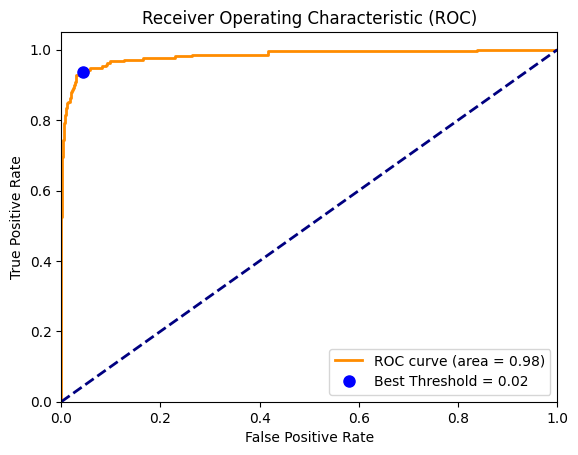

Optimal threshold: 0.020574789494276047
Optimal FPR: 0.043286867204695524, Optimal TPR: 0.9380952380952381
0.04174051


In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, prob)

# -------------1ST METHOD-------------

# distance of each point on the ROC curve from the top-left corner
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)

# index of the minimum distance
optimal_idx = np.argmin(distances)

optimal_threshold = thresholds[optimal_idx]
optimal_fpr, optimal_tpr = fpr[optimal_idx], tpr[optimal_idx]

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(optimal_fpr, optimal_tpr, 'bo', markersize=8, label=f'Best Threshold = {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"Optimal threshold: {optimal_threshold}")
print(f"Optimal FPR: {optimal_fpr}, Optimal TPR: {optimal_tpr}")

# ----------- 2ND METHOD ------------------- #

best_threshold = thresholds[np.argmax(tpr - fpr)]
print(best_threshold)

In [ ]:
pip install roc-utils

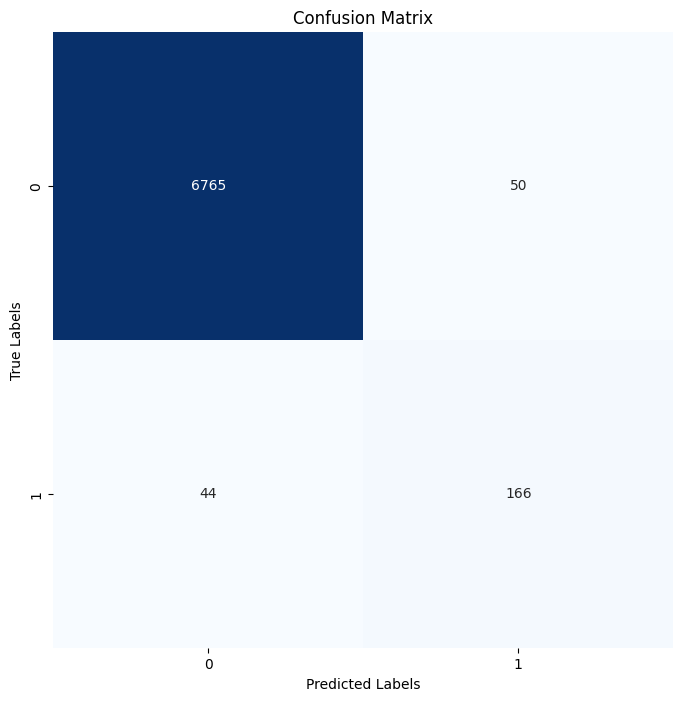

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_names_binary)
ax.yaxis.set_ticklabels(target_names_binary)
plt.show()

Available keys: ['fpr', 'tpr', 'thr', 'auc', 'opd', 'inv']
0.8810282414886615
{'minopt': struct(**{'ind': 2, 'opt': 0.0, 'opp': (0.006462035541195477, 0.7685185185185185), 'opa': 0.9866192170818505, 'opo': -0.23157166098682527, 'opq': ((0, 1), (0.762056482977323, 1.7620564829773229))}), 'minoptsym': struct(**{'ind': 2, 'opt': 0.0, 'opp': (0.006462035541195477, 0.7685185185185185), 'opa': 0.9866192170818505, 'opo': -0.23157166098682527, 'opq': ((0, 1), (0.762056482977323, 1.7620564829773229))}), 'youden': struct(**{'ind': 2, 'opt': 0.0, 'opp': (0.006462035541195477, 0.7685185185185185), 'opa': 0.9866192170818505, 'opo': 0.762056482977323, 'opq': ((0, 1), (0.762056482977323, 1.7620564829773229))}), 'cost': struct(**{'ind': 2, 'opt': 0.0, 'opp': (0.006462035541195477, 0.7685185185185185), 'opa': 0.9866192170818505, 'opo': 0.762056482977323, 'opq': ((0, 1), (0.762056482977323, 1.7620564829773229))}), 'concordance': struct(**{'ind': 2, 'opt': 0.0, 'opp': (0.006462035541195477, 0.76851851851

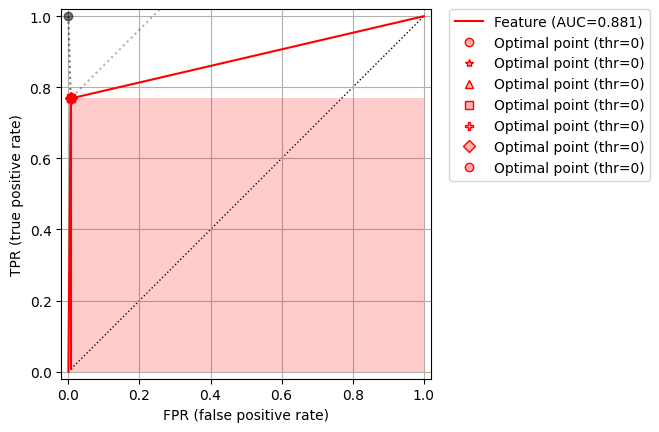

In [20]:
# ---------- 3RD METHOD -----------
from roc_utils import *

roc = compute_roc(true_labels, predicted_labels, pos_label=True,objective=["minopt", "minoptsym",
                             "youden", "cost",
                             "concordance",
                             "acc", "cohen"])
#print(roc)

print("Available keys:", list(roc.keys()))
print(roc.auc)
print(roc.opd)

"""_, ax3 = plt.subplots()
plot_roc(roc, color="red", ax=ax3)
# Place the legend outside.
ax3.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax3.set_title("ROC curves");"""

for key, val in roc.opd.items():
    print("%-15s thr=% .3f, J=%7.3f" % (key+":", val.opt, val.opo) )

plot_roc(roc, show_opt=True)
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)